In [133]:
import umap

import pandas as pd
import numpy as np

from datetime import datetime as dt
from scipy import stats
from itertools import permutations
from tqdm import tqdm
from annoy import AnnoyIndex

from news_vec.encoder import read_preds

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
df, embeds = read_preds('../data/ava-ts-lstm-attn/')

100%|██████████| 361/361 [00:16<00:00, 22.02it/s]


In [3]:
embeds.shape

(360300, 512)

In [5]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.domain}'], 1)

In [25]:
rows = []
for d in df.domain.unique():
    pdf = df[df.domain==d]
    lr = stats.linregress(pdf.decile, pdf.p_true)
    rows.append((d, lr.slope, lr.intercept, lr.rvalue, lr.pvalue))

In [48]:
ova_lr_df = pd.DataFrame(rows, columns=('domain', 'slope', 'intercept', 'r', 'p'))

In [50]:
ova_lr_df.sort_values('slope', ascending=False)

,domain,slope,intercept,r,p
9,buzzfeed.com,0.017350,0.650892,0.143573,8.391104e-111
3,foxnews.com,0.012372,0.179413,0.151312,5.422127e-123
7,dailycaller.com,0.005605,0.295687,0.064363,1.771626e-23
14,breitbart.com,0.002765,0.426550,0.025206,9.345603e-05
8,washingtonpost.com,0.001948,0.243592,0.022363,5.280460e-04
6,apnews.com,0.001521,0.399739,0.016249,1.179195e-02
12,wsj.com,0.001221,0.328447,0.013102,4.230443e-02
10,huffingtonpost.com,-0.000192,0.243462,-0.002443,7.049719e-01
2,npr.org,-0.002029,0.291270,-0.023268,3.104830e-04
4,bloomberg.com,-0.002654,0.453358,-0.024249,1.708635e-04


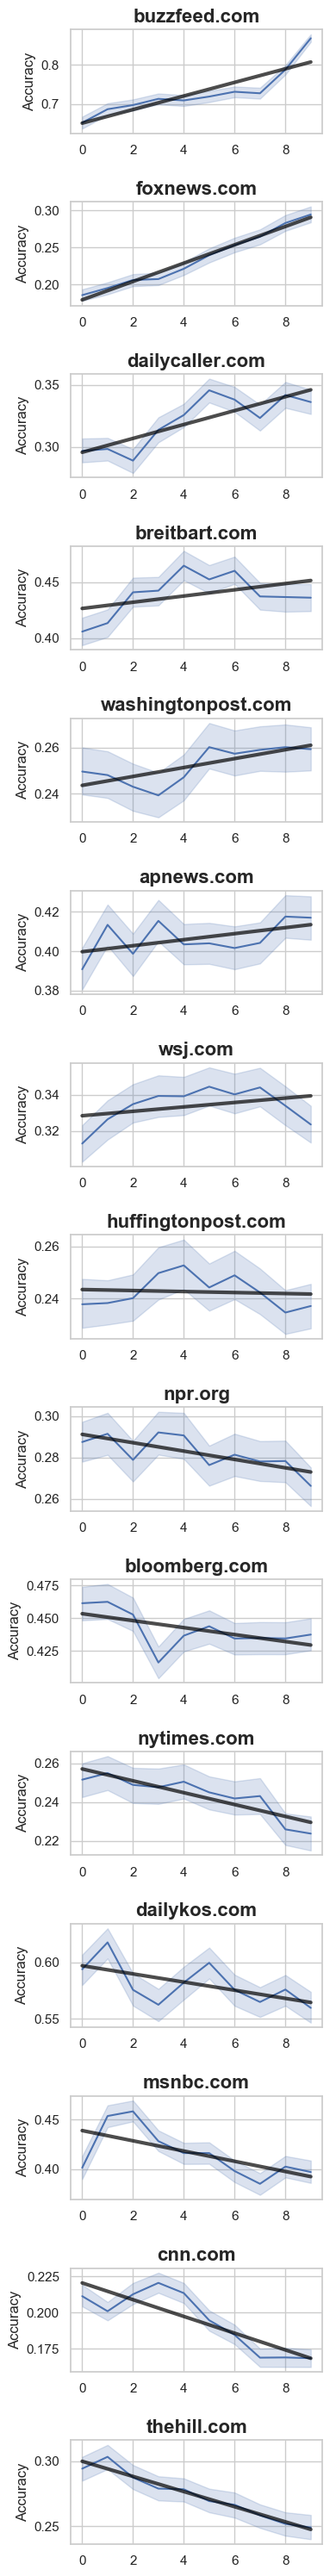

In [51]:
fig, axes = plt.subplots(len(lr_df), 1, figsize=(4,30), dpi=100)

for i, r in enumerate(ova_lr_df.sort_values('slope', ascending=False).itertuples()):
    
    ax = axes[i]
    pdf = df[df.domain==r.domain].sort_values('decile')
    
    fitx = np.array([pdf.decile.min(), pdf.decile.max()])
    fity = r.slope * fitx + r.intercept
    
    sns.lineplot(x='decile', y='p_true', data=pdf, ax=ax)
    ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
    
    ax.set_title(r.domain, fontdict=dict(fontsize=16, fontweight='bold'))
    ax.set_xlabel(None)
    ax.set_ylabel('Accuracy')
    
plt.tight_layout(h_pad=2)

In [52]:
DOMAINS = list(df.domain.unique())

In [62]:
rows = []
for d1, d2 in tqdm(permutations(DOMAINS, 2)):
    pdf = df[df.domain==d1].sort_values('decile')
    d2p = pdf.apply(lambda r: r[f'p_{d2}'], 1)
    lr = stats.linregress(pdf.decile, d2p)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.rvalue, lr.pvalue))

210it [01:36,  2.22it/s]


In [63]:
ab_lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'r', 'p'))

In [69]:
ab_lr_df.sort_values('slope', ascending=False).head(10)

,d1,d2,slope,intercept,r,p
12,thehill.com,dailykos.com,0.003139,0.038104,0.083973,7.557636e-39
13,thehill.com,breitbart.com,0.002841,0.068061,0.069863,2.217221e-27
21,cnn.com,washingtonpost.com,0.002582,0.041597,0.097752,4.410630e-52
110,dailycaller.com,dailykos.com,0.002559,0.058159,0.055810,4.891047e-18
82,msnbc.com,dailykos.com,0.002417,0.044770,0.072771,1.424677e-29
22,cnn.com,buzzfeed.com,0.002262,0.019580,0.069926,1.992303e-27
153,huffingtonpost.com,breitbart.com,0.002220,0.045046,0.060550,5.865316e-21
147,huffingtonpost.com,dailycaller.com,0.002107,0.070369,0.055588,6.608044e-18
26,cnn.com,dailykos.com,0.002065,0.026946,0.067206,1.866283e-25
111,dailycaller.com,breitbart.com,0.002012,0.127574,0.033186,2.683835e-07


In [95]:
def plot_pairs(lr_df, w=4, h=20):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[df.domain==r.d1].sort_values('decile').copy()
        pdf['d2p'] = pdf.apply(lambda ri: ri[f'p_{r.d2}'], 1)

        fitx = np.array([pdf.decile.min(), pdf.decile.max()])
        fity = r.slope * fitx + r.intercept

        sns.lineplot(x='decile', y='d2p', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('d2 probability')

    plt.tight_layout(h_pad=2)
    plt.show()

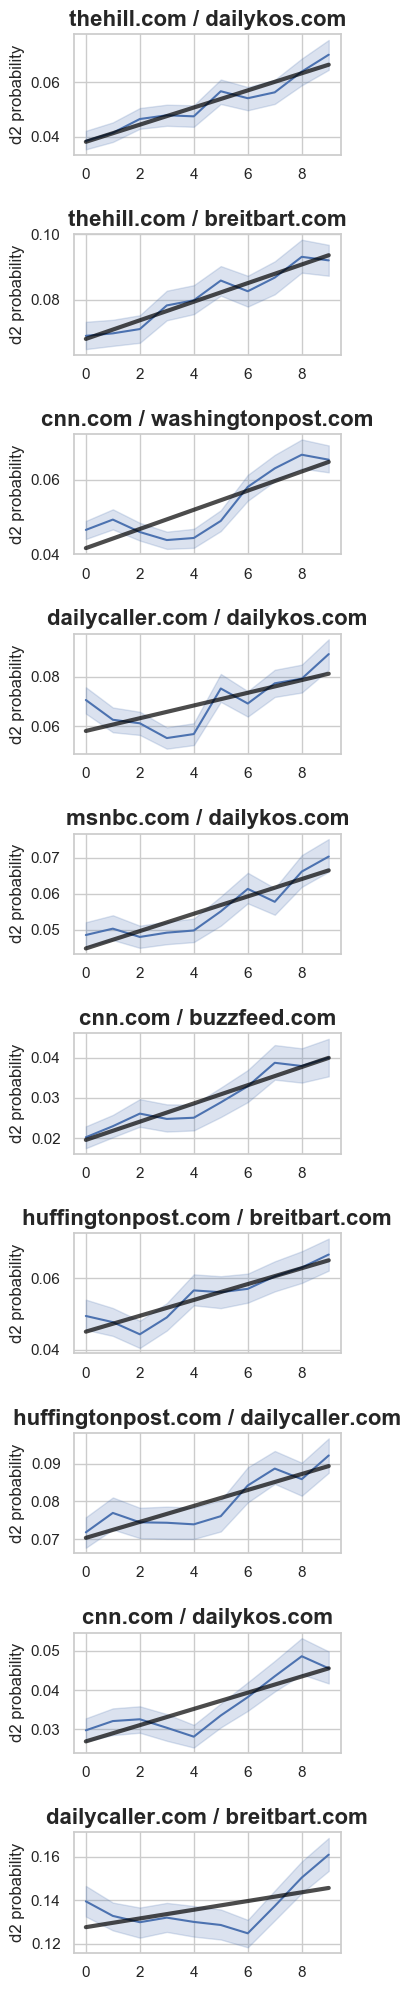

In [96]:
plot_pairs(ab_lr_df.sort_values('slope', ascending=False).head(10))

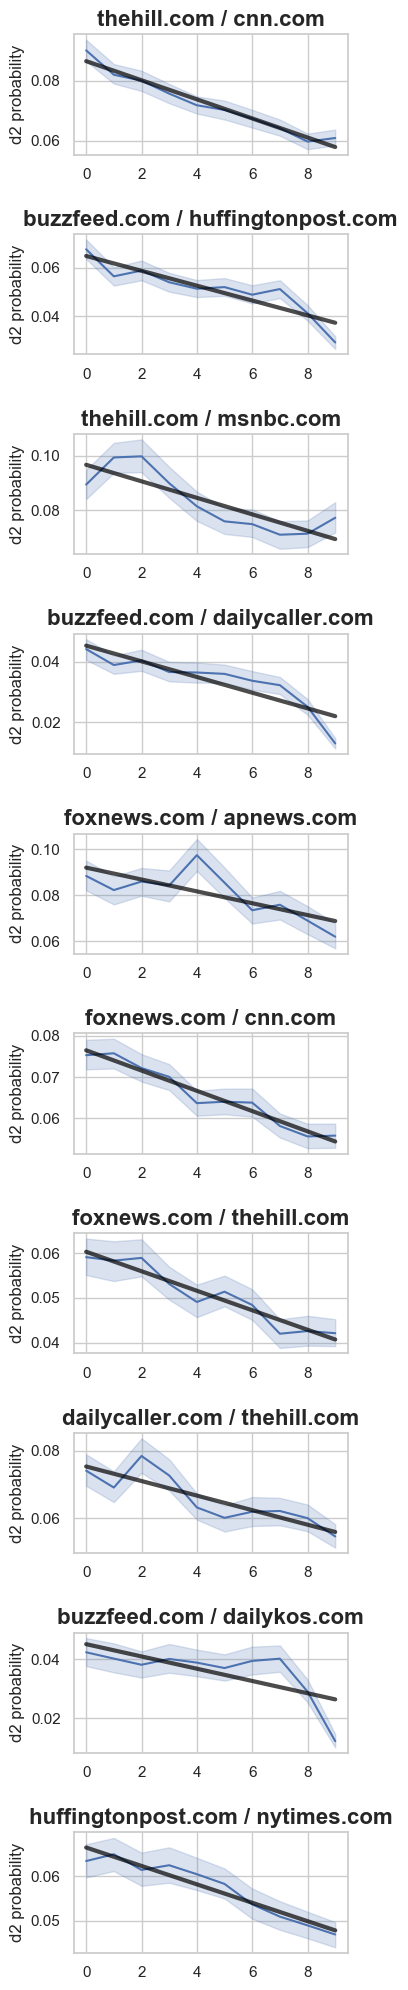

In [98]:
plot_pairs(ab_lr_df.sort_values('slope', ascending=True).head(10))

In [105]:
df_train = df[df.split=='train']

In [111]:
idx = AnnoyIndex(embeds.shape[1])

for r in tqdm(df_train.itertuples()):
    idx.add_item(r.Index, embeds[r.Index])
    
idx.build(20)

288240it [00:21, 13643.71it/s]


True

In [121]:
def delta_hls(df1, df2, n=10):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    for i in idx.get_nns_by_vector(v2-v1, n):
        print(' '.join(df.loc[i].clf_tokens))

In [123]:
delta_hls(
    df[(df.domain=='foxnews.com')&(df.decile==1)],
    df[(df.domain=='foxnews.com')&(df.decile==9)],
)

naked man in wisconsin catches fire during arrest after a taze gone wrong police video shows
las vegas massacre body cam shows terrified officer avoid confrontation with stephen paddock
smith college empl calls popo on student eating lunch while black she seemed to be out of place
new york man accused of snapping ex wife s parakeet in half threatening her takes plea deal
wwii era money worth $ # m found under store that belonged to winston churchill s tailor
family witnesses blast nypd after brooklyn man killed by officers while wielding pipe resembling gun
dash cam footage shows ohio cop s blatant abuses of power against daughter s boyfriend and friends
dash cam footage shows ohio cop s blatant abuses of power against daughter s boyfriend and friends
nbc announces today show co host matt lauer fired due to inappropriate sexual behavior at work
marine recruit needed skin grafts to treat chemical burns suffered at boot camp documents reveal


In [124]:
delta_hls(
    df[(df.domain=='foxnews.com')&(df.decile==9)],
    df[(df.domain=='foxnews.com')&(df.decile==1)],
)

trump to issue stop payment order on health care subsidies
puerto rico s bankruptcy advisers could get closer scrutiny
trump wants health care bill to protect pre existing conditions
trump aims to pervert census count with citizenship question
trump s cuts to health law enrollment efforts are hitting hard
epa eases rules on how coal ash waste is stored across us
rising coal exports give short term aid to an ailing industry
twitter efforts to fight russian accounts called inadequate
uncertainty lingers as insurers grapple with health care s future
trump takes credit for positive jobs report stock market climb


In [125]:
delta_hls(
    df[(df.domain=='buzzfeed.com')&(df.decile==1)],
    df[(df.domain=='buzzfeed.com')&(df.decile==9)],
)

build a breakfast and we ll tell you what dog breed you are
which dog breed are you based on your pizza preferences
shop at gucci and we ll reveal which dog breed you are
shop at gucci and we ll reveal which dog breed you are
pick some disney characters and we ll tell you which disney princess is your soulmate
plan a wedding and we ll tell you which disney princess you are
pick some disney movies and we ll reveal your disney soulmate
pick # desserts and we ll guess your favorite season
build a disney villain and we ll tell you which disney princess you are
order from mcdonald s and we ll tell you which celeb you are


In [126]:
delta_hls(
    df[(df.domain=='buzzfeed.com')&(df.decile==9)],
    df[(df.domain=='buzzfeed.com')&(df.decile==1)],
)

tillerson to shutter war crimes focused state dept office
nunes to lebron brace yourself for california s taxes
nunes to lebron brace yourself for california s taxes
woodward book shames trump shills apologists and enablers
tillerson out at state to be replaced by cia chief pompeo
late anonymous letter against kavanaugh not good
cuomo gop tax law economic civil war on blue states
kerry sees new era of accountability heralded by # races
sessions sad political stunts wo nt work in california
thanks to quirky senate rules mccain to question comey


In [127]:
delta_hls(
    df[(df.domain=='huffingtonpost.com')&(df.decile==1)],
    df[(df.domain=='huffingtonpost.com')&(df.decile==9)],
)

protester holds sign blasting trump as coward mccain as hero during funeral procession
rand paul rips dems anti trump conservatives for destroying diplomatic engagement with russia
hollywood rips trump for joe arpaio pardon america knowingly elected a racist president
gop chairwoman rips omarosa over taping kelly if she broke the law she should be prosecuted
left attacks ivanka trump for wh photo shoot with canadian pm trudeau in oval office
celebrity chef rips trump for building golf course sea wall while denying global warming
country singer eric church blames nra for inaction on gun control after las vegas shooting
stephen miller jabs back at nyt reporter about time we had compassion for american workers
stephen miller jabs back at nyt reporter about time we had compassion for american workers
rnc chair ronna romney mcdaniel getting things done in washington key to # election


In [128]:
delta_hls(
    df[(df.domain=='huffingtonpost.com')&(df.decile==9)],
    df[(df.domain=='huffingtonpost.com')&(df.decile==1)],
)

how some states are helping first time home buyers
how affordable urban housing stays affordable
faq city how did charlotte become a banking city
why some workers are seeing unexpected pay raises
how big banks bled a tiny island nation
in the catalan standoff a third party benefits
ask a designer rethinking the holiday dining room
how to shop for a plan in the aca marketplace
how other countries freeload on us drug research
why many home buyers suddenly feel cursed


In [181]:
pdf = df_train[df_train.domain.isin(['huffingtonpost.com', 'buzzfeed.com'])].copy()
pdf['tokens_key'] = pdf.clf_tokens.apply(lambda ts: tuple(ts))
pdf = pdf.drop_duplicates('tokens_key')

dr = umap.UMAP(metric='cosine', verbose=True)
UMAP_EMBEDDING = dr.fit_transform(embeds[pdf.index])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


In [182]:
UMAP_POINTS = pdf.copy()
UMAP_POINTS['x'] = UMAP_EMBEDDING[:,0]
UMAP_POINTS['y'] = UMAP_EMBEDDING[:,1]

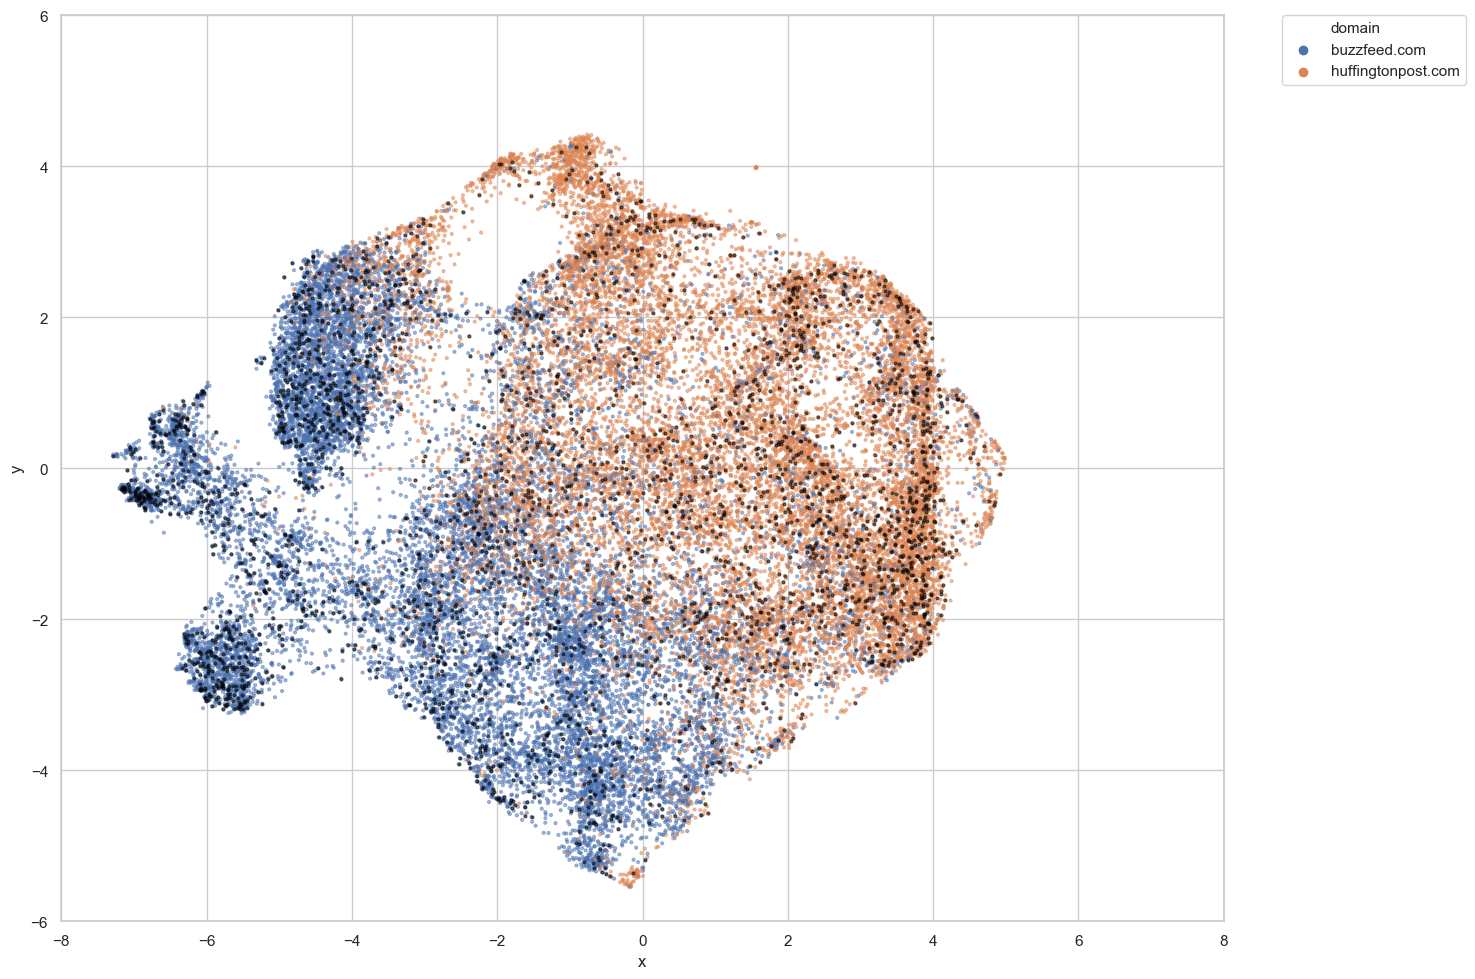

In [183]:
plt.figure(figsize=(15,12), dpi=100)
plt.xlim(-8,8)
plt.ylim(-6,6)

sns.scatterplot(
    x='x',
    y='y',
    data=UMAP_POINTS,
    s=5,
    edgecolor=None,
    alpha=0.5,
    hue='domain',
)

sns.scatterplot(
    x='x',
    y='y',
    data=UMAP_POINTS[UMAP_POINTS.decile==9],
    s=5,
    edgecolor=None,
    alpha=0.5,
    color='black'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
(alt
    .Chart(UMAP_POINTS.sample(frac=0.1), width=500, height=500)
    .mark_point()
    .encode(x='x', y='y', tooltip='title', color='domain'))